**EE-411 Homework 3 : Neural Networks**

*Name : Palmisano*

*First Name : Fabio Nicola Edouard*

*Sciper = 296708*


## **Part 1 : Backpropagation with logistic loss**

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

In [36]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)

## 1.1) Function Predict:

In [50]:
# X : Array of shape B X D, W = {w_1 : D x K, w_2 : K x 1}

#Directly taken from the TP9

def np_sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def predict(X,W) :
    x_0 = X
    z_1 = np.dot(X,W["w_1"])
    X_1 = np_sigmoid(z_1)
    z_2 = np.dot(X_1,W["w_2"])
    y_hat = np_sigmoid(z_2)
    return (z_1, z_2, y_hat)




In [53]:
D = 7
K = 5
B = 100

X = np.random.rand(B, D)
W = {"w_1": np.random.rand(D, K), "w_2": np.random.rand(K, 1)}

z_1, z_2, y_hat = predict(X, W)
print(z_1.shape)
print(z_2.shape)
print(y_hat.shape)


(100, 5)
(100, 1)
(100, 1)


## 1.2) Function Logistic Loss:

In [63]:
import numpy as np

def logistic_loss(y, y_hat):
    """Compute the average logistic loss of a batch."""
    avg_log_loss = np.mean(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat))
    return avg_log_loss

In [73]:
y_hat = np.zeros((B, 1))
y = np.zeros((B, 1))
loss = logistic_loss(y, y_hat)
print(f"loss = {loss}")

loss = nan


It equal to zero because we can't calcul the logarithm of zero so that give us the Nan result. 

## 1.3) Function  stable logistic loss:

In [78]:
import numpy as np

def stable_logistic_loss(y, z2):
    """Compute the average stable logistic loss of a batch."""
    avg_loss = np.mean(np.logaddexp(0, -z2) + (1-y) * z2)
    return avg_loss

z2 = -10e10 * np.ones(B)
y = np.zeros((B, 1))
stable_loss = stable_logistic_loss(y, z2)
print(f"stable_loss = {stable_loss:.3f}")

stable_loss = 0.000


So we have a stable implementation of our logistic loss. 

## 1.4) Derive Analytically (Notebook)

## 1.5) Implement Gradient

In [ ]:
def gradient(X, y, W):
    """Compute the gradient of the average loss with respect to all the weights."""
    z_1, z_2, y_hat = predict(X, W)
    dL_dy_hat = (1/B) * (y_hat - y)
    dL_dz_2 = dL_dy_hat * y_hat * (1 - y_hat)
    dL_dX_1 = np.dot(dL_dz_2, W["w_2"].T)
    dL_dz_1 = dL_dX_1 * z_1 * (1 - z_1)
    dL_dW_2 = np.dot(z_1.T, dL_dz_2)
    dL_dW_1 = np.dot(X.T, dL_dz_1)
    gradient = {"dL_dW_1": dL_dW_1, "dL_dW_2": dL_dW_2}
    return gradient


## **Part 2 : Classifying KMNIST using neural networks**

In [79]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

In [81]:
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01
EPOCHS = 20


In [86]:
transform = T.Compose([T.ToTensor()])

# load the train dataset
train_dataset = torchvision.datasets.KMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.KMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

# Create the validation dataset from the train dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [89]:
# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)
    

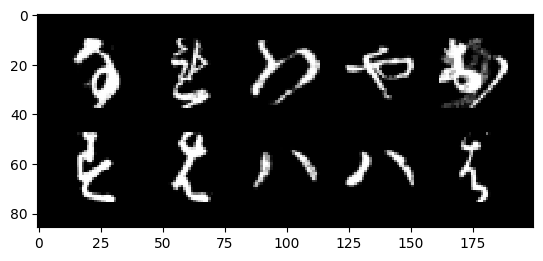

In [90]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

### ANSWER THE Q

## 2.2) MLP

In [111]:
def device_type():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'
DEVICE = torch.device(device_type())
print(DEVICE)

cpu


In [112]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        output = self.fc3(x)
        return output


In [113]:
accuracies = []
models = []
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''
    models.append(model)
    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        loss = F.cross_entropy(output, target)

        # compute the gradients
        loss.backward()


        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)


def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        #print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)
    print('Finished Training')
    return losses

def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)
    accuracies.append(accuracy)
    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')


SGD with LR = 0.01
Finished Training
Test set: Avg. loss: 0.0015, Accuracy: 5461/10000 (55%)
SGD with LR = 0.01, momentum = 0.9, nestrov = True
Finished Training
Test set: Avg. loss: 0.0007, Accuracy: 7900/10000 (79%)
Adam with LR = 0.01
Finished Training
Test set: Avg. loss: 0.0008, Accuracy: 8812/10000 (88%)
Adam with LR = 1
Finished Training
Test set: Avg. loss: 0.0023, Accuracy: 1000/10000 (10%)


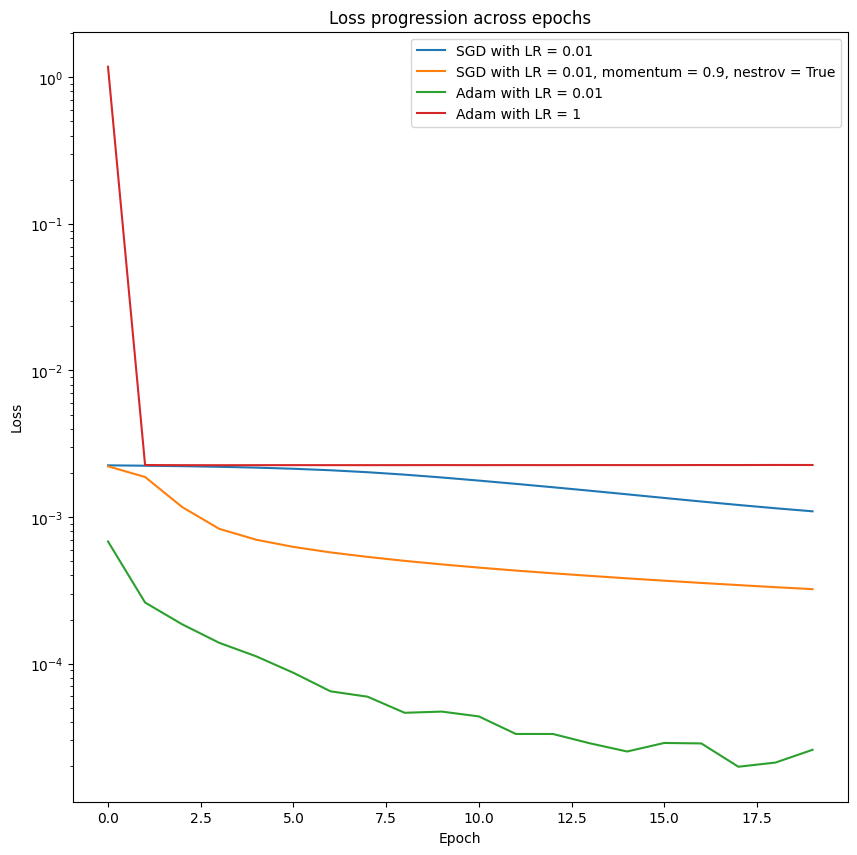

In [114]:
plt.figure(figsize=(10, 10))
#Model with Optimizer : SGD and Learning Rate : 0.01
modelSGD_001 = Net()
optimizerSGD_001 = optim.SGD(modelSGD_001.parameters(), lr=0.01)
print('SGD with LR = 0.01')
lossesSGD_001 = fit(modelSGD_001, train_dataloader, optimizerSGD_001, EPOCHS, device = DEVICE)
predict(modelSGD_001, test_dataloader, device = DEVICE)
plt.plot(lossesSGD_001, label = "SGD with LR = 0.01")

#Model with Optimizer : SGD with momentum and Learning Rate : 0.01, momentum : 0.9, nestrov : True
modelSGD_001_momentum = Net()
optimizerSGD_001_momentum = optim.SGD(modelSGD_001_momentum.parameters(), lr=0.01, momentum=0.9, nesterov=True)
print('SGD with LR = 0.01, momentum = 0.9, nestrov = True')
lossesSGD_001_momentum = fit(modelSGD_001_momentum, train_dataloader, optimizerSGD_001_momentum, EPOCHS, device = DEVICE)
predict(modelSGD_001_momentum, test_dataloader, device = DEVICE)
plt.plot(lossesSGD_001_momentum, label = "SGD with LR = 0.01, momentum = 0.9, nestrov = True")

#Model with Adam Optimizer and Learning Rate : 0.01
modelAdam_001 = Net()
optimizerAdam_001 = optim.Adam(modelAdam_001.parameters(), lr=0.01)
print('Adam with LR = 0.01')
lossesAdam_001 = fit(modelAdam_001, train_dataloader, optimizerAdam_001, EPOCHS, device = DEVICE)
predict(modelAdam_001, test_dataloader, device = DEVICE)
plt.plot(lossesAdam_001, label = "Adam with LR = 0.01")

#Model with Adam Optimizer and Learning Rate : 1
modelAdam_1 = Net()
optimizerAdam_1 = optim.Adam(modelAdam_1.parameters(), lr=1)
print('Adam with LR = 1')
lossesAdam_1 = fit(modelAdam_1, train_dataloader, optimizerAdam_1, EPOCHS, device = DEVICE)
predict(modelAdam_1, test_dataloader, device = DEVICE)
plt.plot(lossesAdam_1,  label = "Adam with LR = 1")


plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss progression across epochs")
plt.show()

In [115]:
print('Validation Accuracy with SGD with LR = 0.01')
predict(modelSGD_001, validation_dataloader, device = DEVICE)
models.append('modelSGD_001')
print('----------------------------------------------------------------------')
print('Validation Accuracy with SGD with LR = 0.01, momentum = 0.9, nestrov = True')
predict(modelSGD_001_momentum, validation_dataloader, device = DEVICE)
models.append('modelSGD_001_momentum')
print('----------------------------------------------------------------------')
print('Validation Accuracy with Adam with LR = 0.01')
predict(modelAdam_001, validation_dataloader, device = DEVICE)
models.append('modelAdam_001')
print('----------------------------------------------------------------------')
print('Validation Accuracy with Adam with LR = 1')
models.append('modelAdam_1')
predict(modelAdam_1, validation_dataloader, device = DEVICE)


Validation Accuracy with SGD with LR = 0.01
Test set: Avg. loss: 0.0005, Accuracy: 7109/10000 (71%)
----------------------------------------------------------------------
Validation Accuracy with SGD with LR = 0.01, momentum = 0.9, nestrov = True
Test set: Avg. loss: 0.0002, Accuracy: 8943/10000 (89%)
----------------------------------------------------------------------
Validation Accuracy with Adam with LR = 0.01
Test set: Avg. loss: 0.0002, Accuracy: 9459/10000 (95%)
----------------------------------------------------------------------
Validation Accuracy with Adam with LR = 1
Test set: Avg. loss: 0.0012, Accuracy: 1009/10000 (10%)


We can directly see that the model with SGD with momentum have a higher Accuracy score. However we can do better taking the optimizer Adam but with a learning rate not too big. 

## 2.3) Same but with CNN 

In [116]:
class CNN(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


SGD in CNN with LR = 0.01
Finished Training
Test set: Avg. loss: 0.0015, Accuracy: 4810/10000 (48%)
SGD in CNN with LR = 0.01, momentum = 0.9, nestrov = True
Finished Training
Test set: Avg. loss: 0.0006, Accuracy: 8140/10000 (81%)
Adam in CNN with LR = 0.01
Finished Training
Test set: Avg. loss: 0.0005, Accuracy: 8946/10000 (89%)
Adam in CNN with LR = 1
Finished Training
Test set: Avg. loss: 0.0023, Accuracy: 1000/10000 (10%)


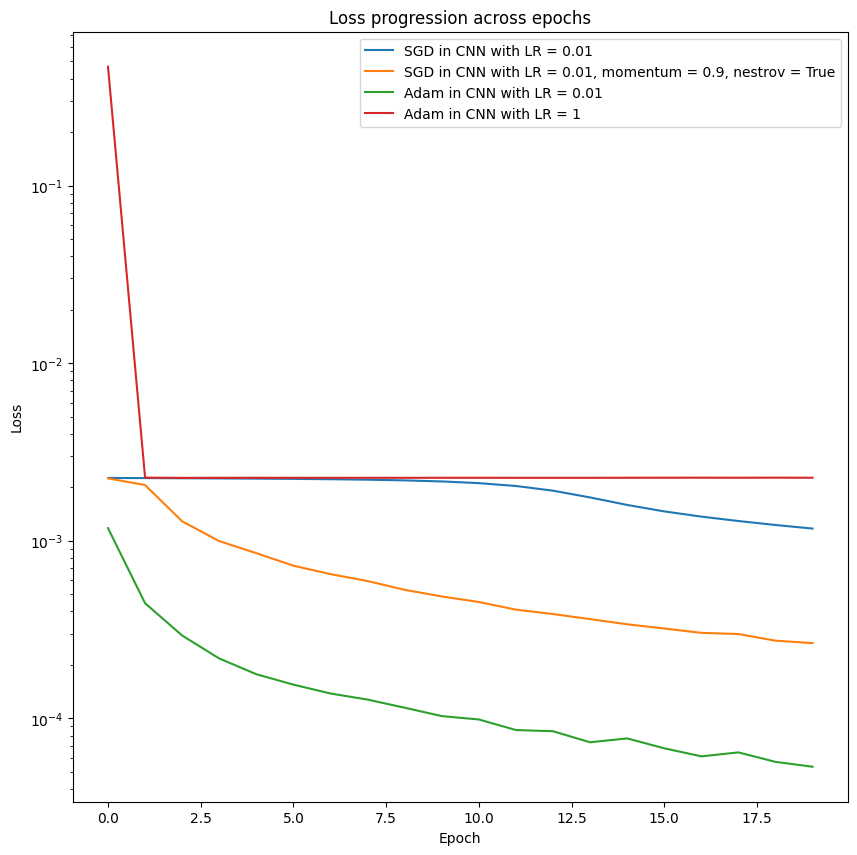

In [117]:
plt.figure(figsize=(10, 10))
#Model with Optimizer : SGD and Learning Rate : 0.01
modelSGD_001_CNN = CNN()
optimizerSGD_001_CNN = optim.SGD(modelSGD_001_CNN.parameters(), lr=0.01)
print('SGD in CNN with LR = 0.01')
lossesSGD_001_CNN = fit(modelSGD_001_CNN, train_dataloader, optimizerSGD_001_CNN, EPOCHS, device = DEVICE)
predict(modelSGD_001_CNN, test_dataloader, device = DEVICE)
plt.plot(lossesSGD_001_CNN, label = "SGD in CNN with LR = 0.01")

#Model with Optimizer : SGD with momentum and Learning Rate : 0.01, momentum : 0.9, nestrov : True
modelSGD_001_momentum_CNN = CNN()
optimizerSGD_001_momentum_CNN = optim.SGD(modelSGD_001_momentum_CNN.parameters(), lr=0.01, momentum=0.9, nesterov=True)
print('SGD in CNN with LR = 0.01, momentum = 0.9, nestrov = True')
lossesSGD_001_momentum_CNN = fit(modelSGD_001_momentum_CNN, train_dataloader, optimizerSGD_001_momentum_CNN, EPOCHS, device = DEVICE)
predict(modelSGD_001_momentum_CNN, test_dataloader, device = DEVICE)
plt.plot(lossesSGD_001_momentum_CNN, label = "SGD in CNN with LR = 0.01, momentum = 0.9, nestrov = True")

#Model with Adam Optimizer and Learning Rate : 0.01
modelAdam_001_CNN = CNN()
optimizerAdam_001_CNN = optim.Adam(modelAdam_001_CNN.parameters(), lr=0.01)
print('Adam in CNN with LR = 0.01')
lossesAdam_001_CNN = fit(modelAdam_001_CNN, train_dataloader, optimizerAdam_001_CNN, EPOCHS, device = DEVICE)
predict(modelAdam_001_CNN, test_dataloader, device = DEVICE)
plt.plot(lossesAdam_001_CNN, label = "Adam in CNN with LR = 0.01")

#Model with Adam Optimizer and Learning Rate : 1
modelAdam_1_CNN = CNN()
optimizerAdam_1_CNN = optim.Adam(modelAdam_1_CNN.parameters(), lr=1)
print('Adam in CNN with LR = 1')
lossesAdam_1_CNN = fit(modelAdam_1_CNN, train_dataloader, optimizerAdam_1_CNN, EPOCHS, device = DEVICE)
predict(modelAdam_1_CNN, test_dataloader, device = DEVICE)
plt.plot(lossesAdam_1_CNN,  label = "Adam in CNN with LR = 1")




plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss progression across epochs")
plt.show()